In [1]:
from xai import *
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import os
from tqdm import tqdm

In [2]:
save_folder = "./images/mnist-latent-explanation"
samples_path = "images/samples"
algorithms = ["exact", "permutation", "deep", "kernel", "gradient"]
latent_dim = 8
rows = 10
columns = latent_dim + 3

In [3]:
try:
    mnist = MNIST.load("mnist.model")
except FileNotFoundError:
    mnist = MNIST(
        latent_shape=(latent_dim,), 
        hidden_layers=2, 
        classifier_head_output_activation="Softmax",
        ) 
    
    mnist.fit_autoencoder(
        epochs=10_000,
        batch_size=256,
        loss_criterion="MSELoss",
        early_stop_cont=750,
        verbose=True,
        info="Mnist autoencoder train"
    )

    mnist.fit_classifier_head(
        epochs=10_000,
        batch_size=256,
        early_stop_cont=750,
        verbose=True,
        info="Mnist classifier-head train"
    )

    mnist.save("mnist.model")
    

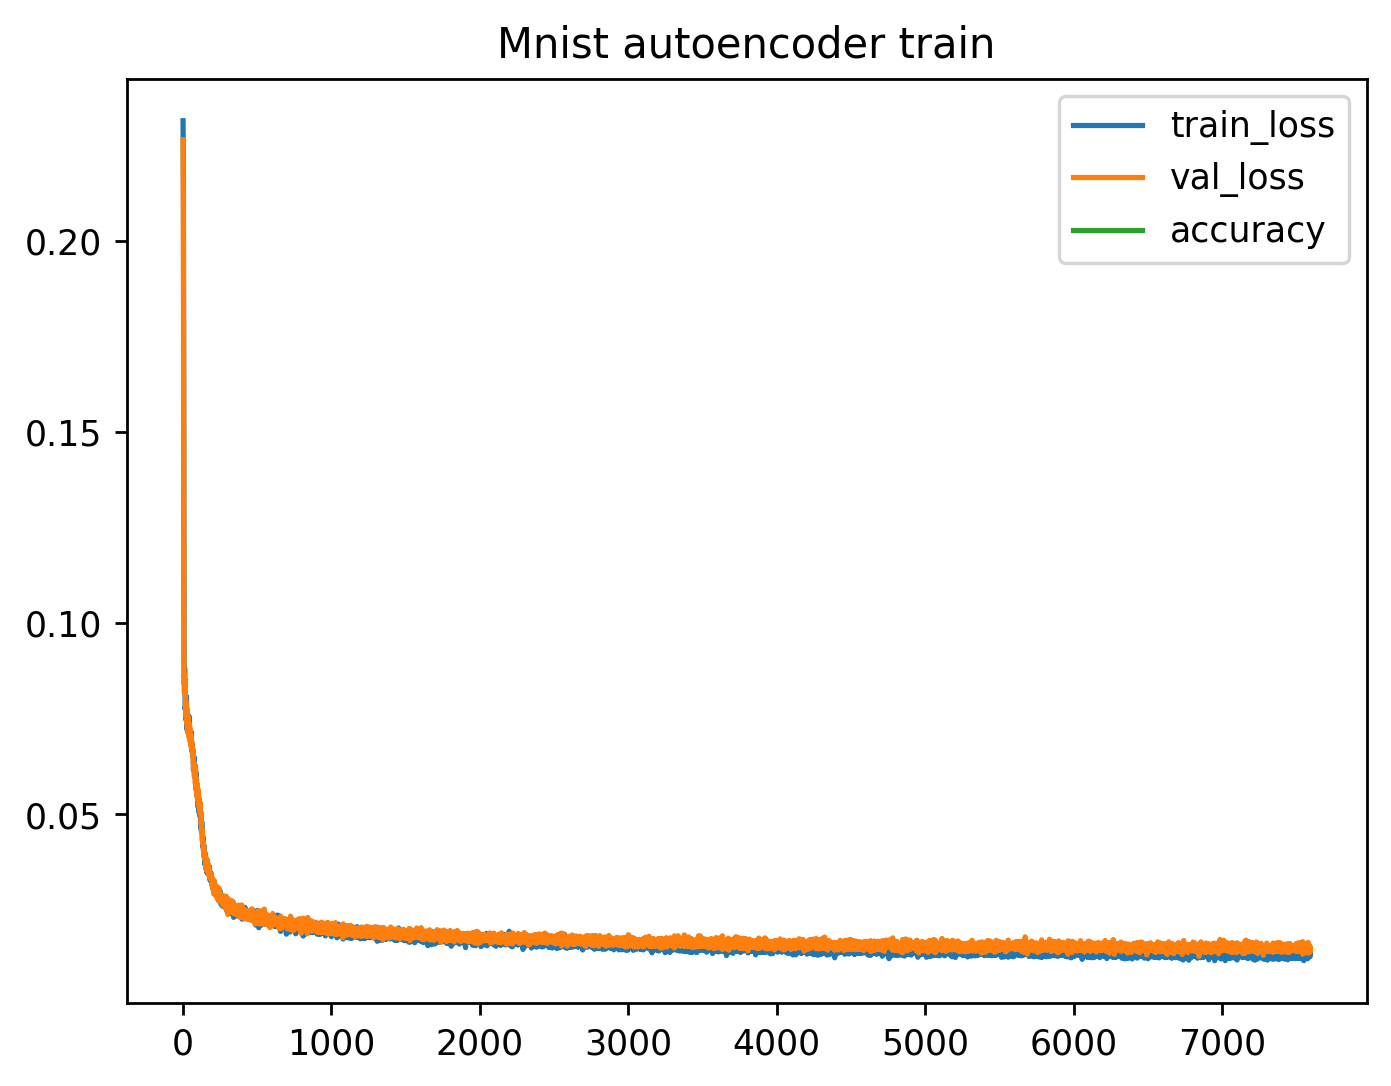

In [4]:
mnist.autoencoder.train_history.figure("Mnist autoencoder train")

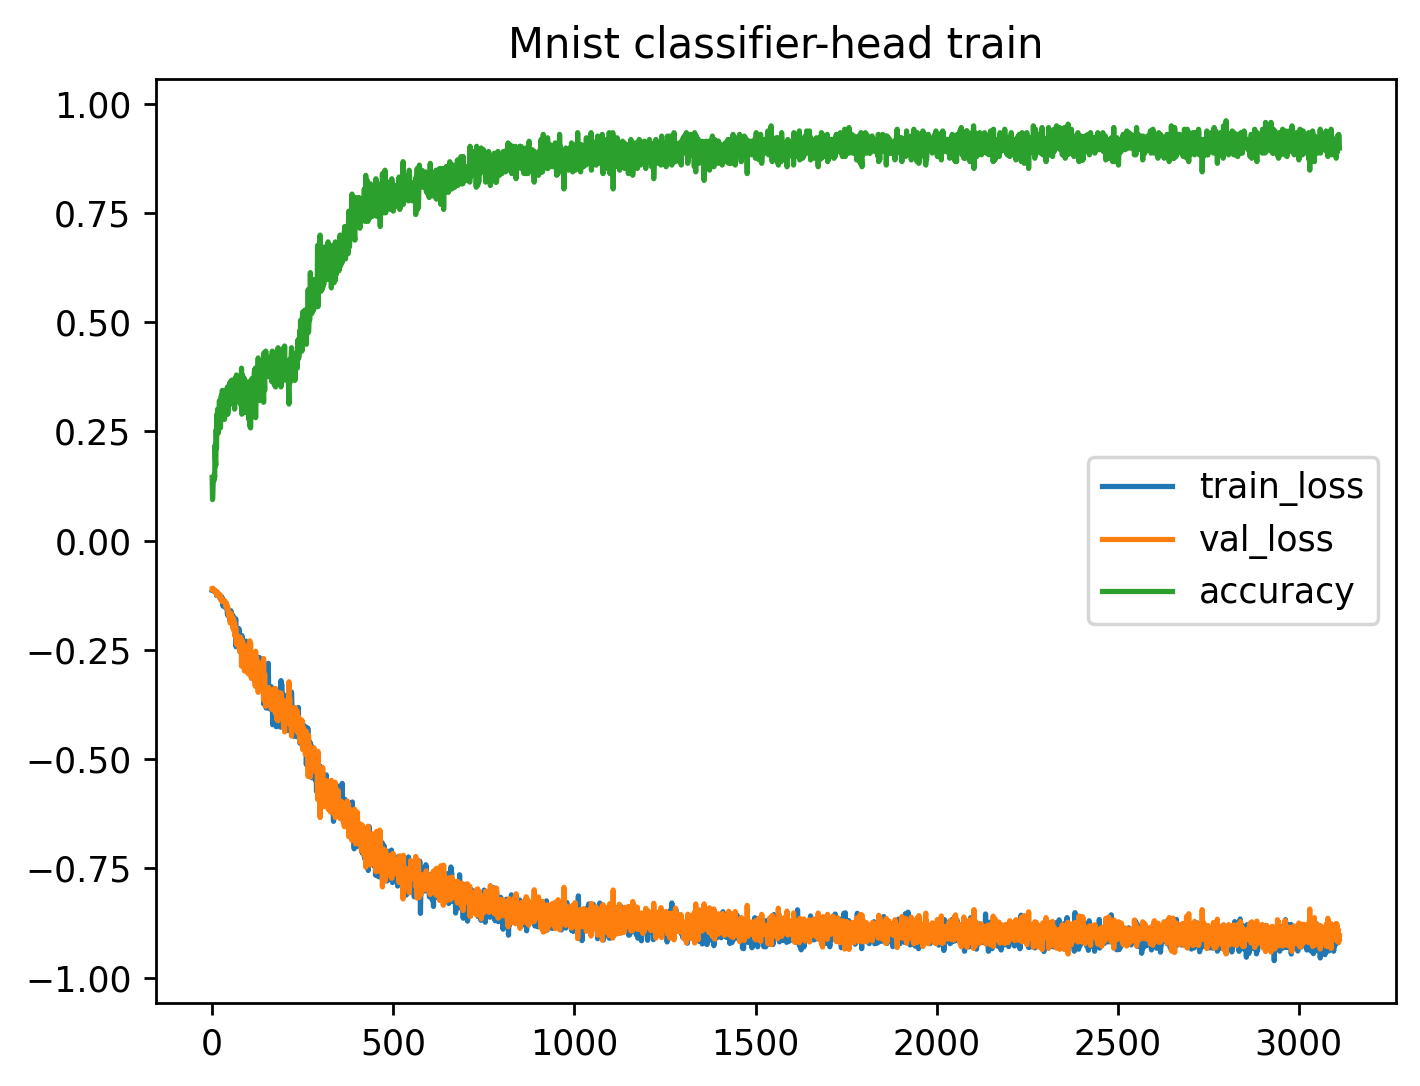

In [5]:
mnist.classifier_head.train_history.figure("Mnist classifier-head train")

In [6]:
try:
    os.mkdir(save_folder)
except:
    pass

for algorithm in algorithms:
    try:
        os.mkdir(f"{save_folder}/{algorithm}")
    except:
        pass

try:
    samples = Stream.load(samples_path, Tuple[torch.Tensor,torch.Tensor]).list()
except:
    samples: List[torch.Tensor,torch.Tensor] = []
    for i in range(rows):
        samples.append(mnist.get_sample(digit=i))

    Stream(samples).save(samples_path)

DeepExplainer:   0%|          | 0/10 [00:00<?, ?it/s]unrecognized nn.Module: Lambda
CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
KernelExplainer:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  10%|█         | 1/10 [00:03<00:28,  3.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  20%|██        | 2/10 [00:06<00:25,  3.15s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  30%|███       | 3/10 [00:09<00:22,  3.27s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  40%|████      | 4/10 [00:12<00:19,  3.24s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  50%|█████     | 5/10 [00:16<00:16,  3.35s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

KernelExplainer:  60%|██████    | 6/10 [00:20<00:13,  3.39s/it]


KeyboardInterrupt: 

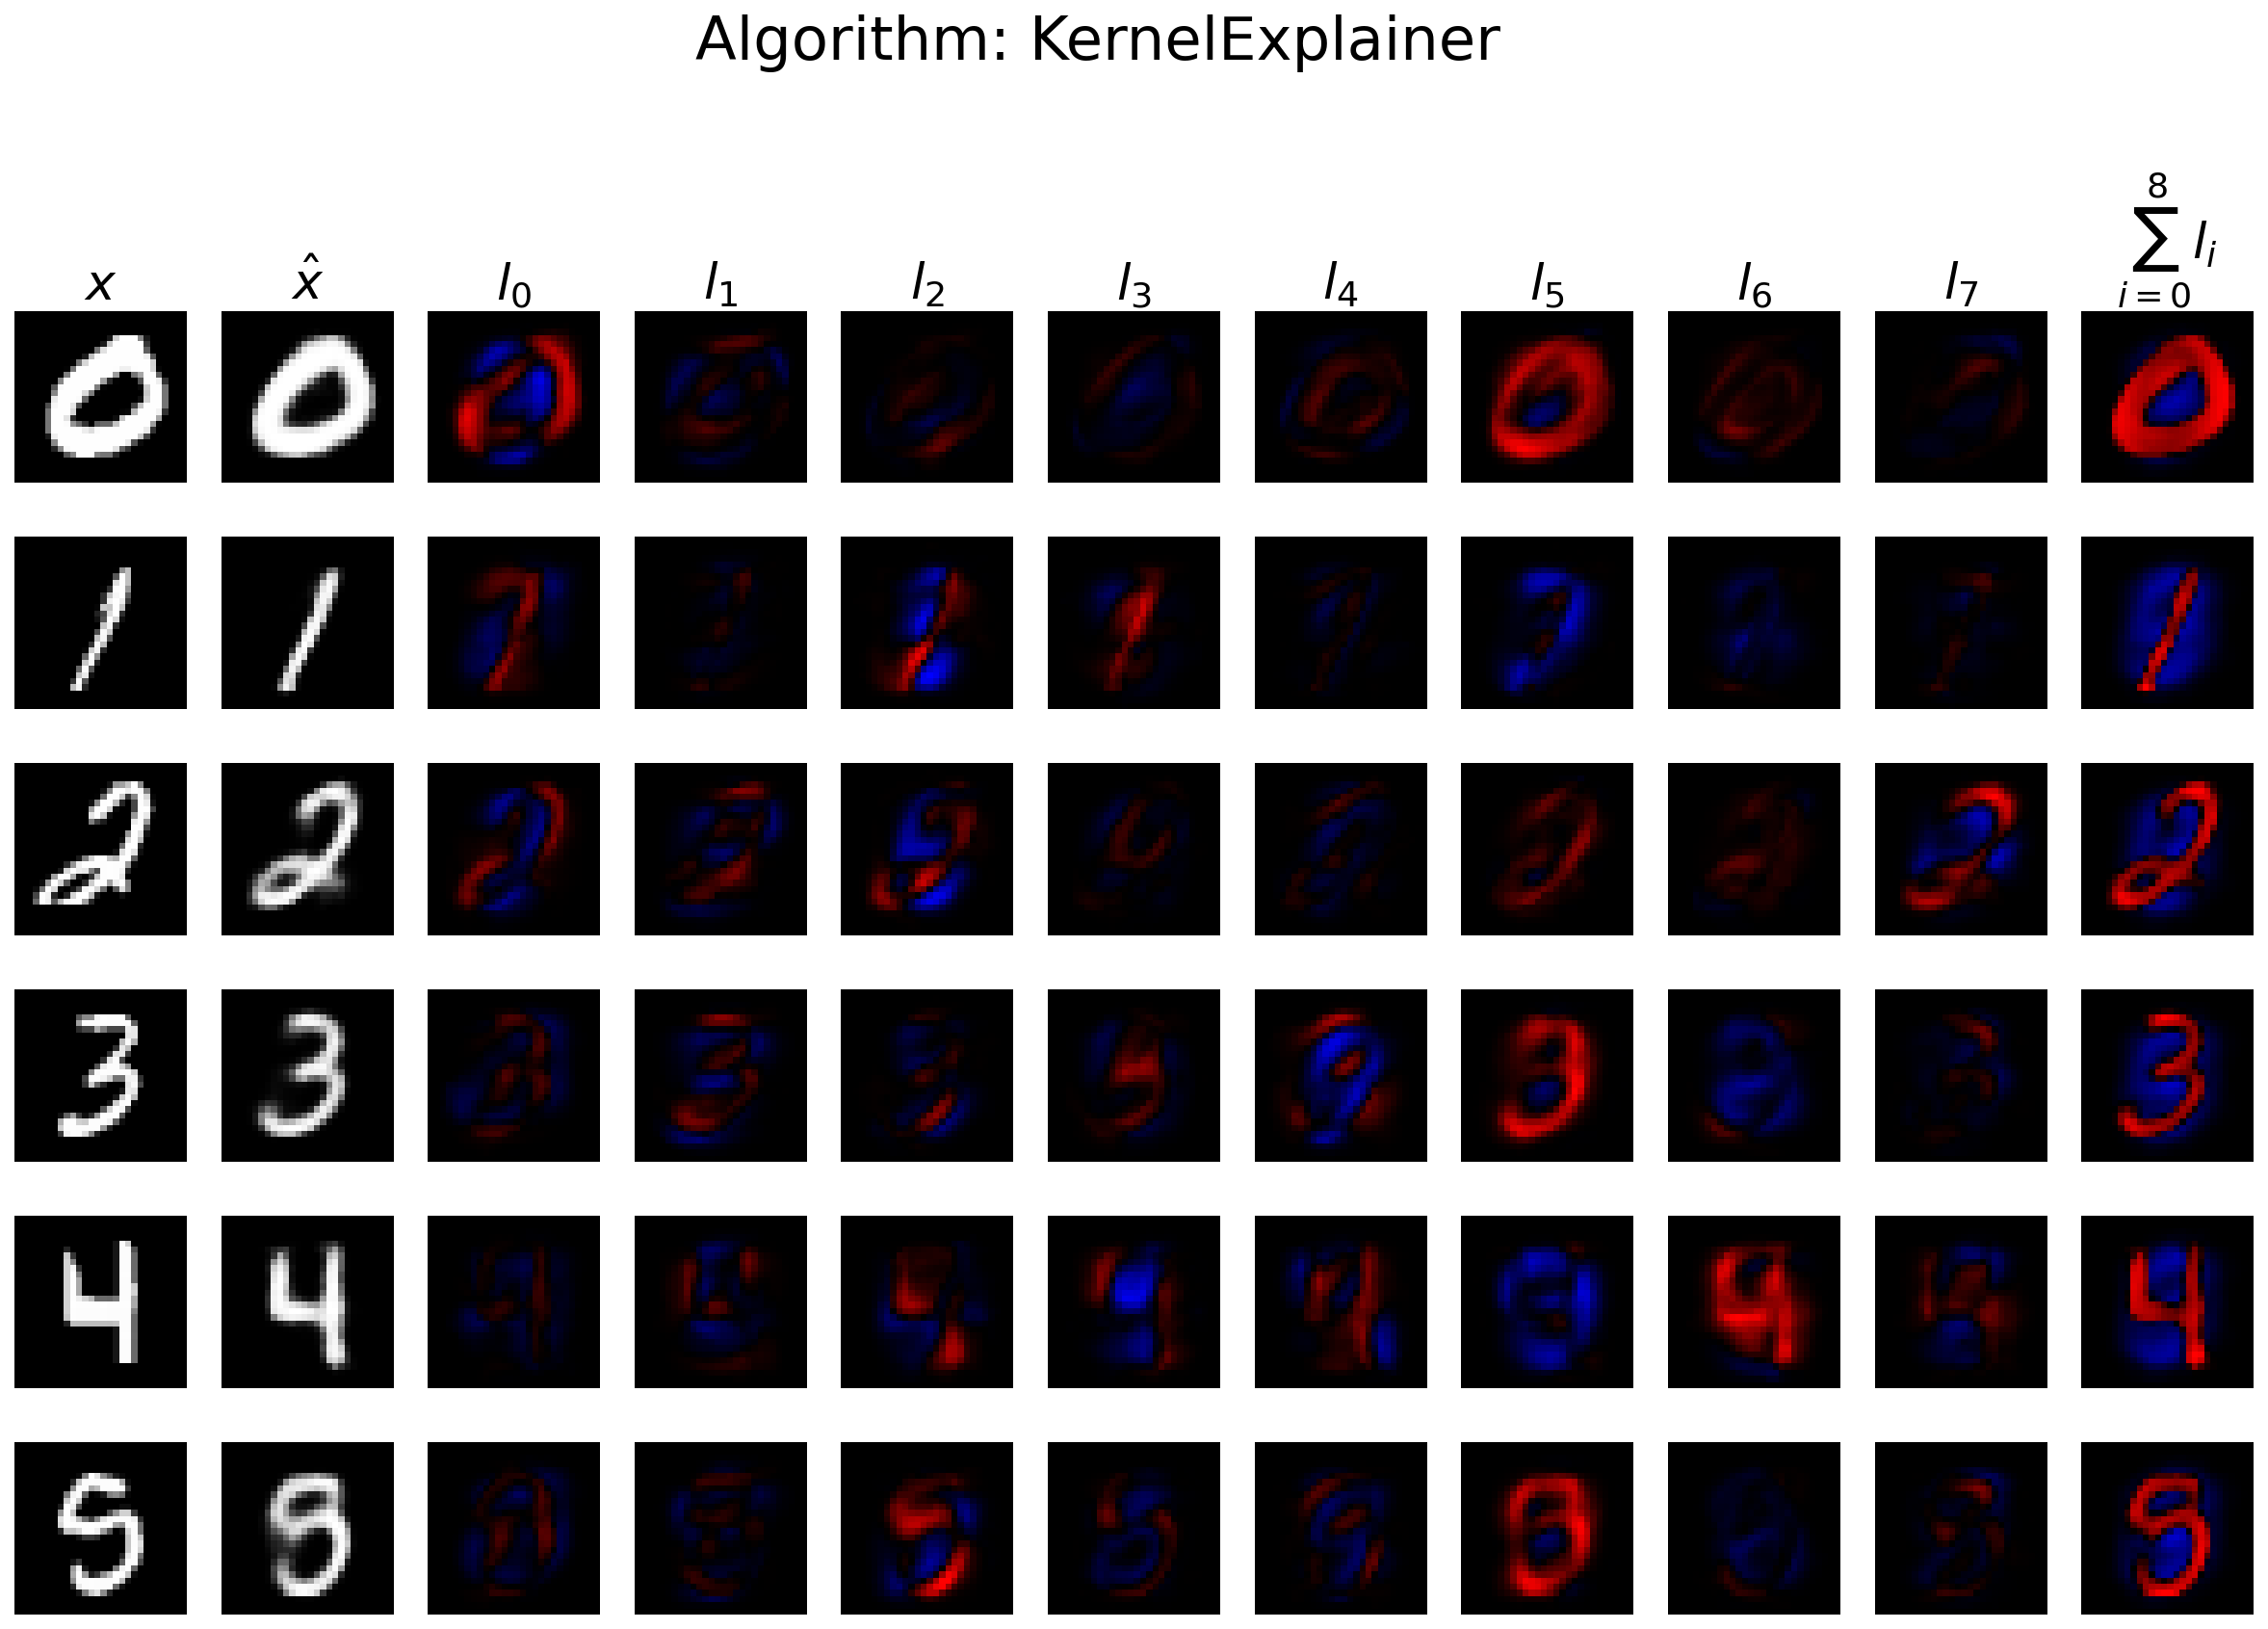

In [7]:
def mk_shap_latent_plot(algorithm: Explainers):
    fig = plt.figure(dpi=150, figsize=(20,20)) 
    fig.suptitle(f"Algorithm: {algorithm.capitalize()}Explainer", size=30)

    def save_mnist(image: np.ndarray, path: str, **args) -> None:
        plt.imsave(path, image.repeat(16,0).repeat(16,1), **args)

    compute_times = []

    with tqdm(total=rows, desc=f"{algorithm.capitalize()}Explainer") as bar:
        for row in range(rows):
            slot = row*columns

            sample,label = samples[row]
            sample = sample.numpy(force=True)
            label = int(label.item())
            predict = mnist(sample)
            recon = predict.reconstruction().numpy(force=True)

            latent_explanation = predict.reconstruction.explain(algorithm, mnist(mnist.val_data).embedding()).flip()
            shap_values: np.ndarray = latent_explanation.shap_values
            norm = max([np.max(np.abs(shap_values))])

            compute_times.append(latent_explanation.compute_time.float())

            fig.add_subplot(rows,columns,slot+1)
            plt.imshow(sample, cmap="gray")
            plt.axis('off')
            if row == 0:
                plt.title(f"$x$", size=25)
            save_mnist(sample, f"{save_folder}/{algorithm}/sample{row}.png", cmap="gray")
                
            fig.add_subplot(rows,columns,slot+2)
            plt.imshow(recon, cmap="gray")
            plt.axis('off')
            if row == 0:
                plt.title("$\hat{{x}}$", size=25)
            save_mnist(recon, f"{save_folder}/{algorithm}/reconstruction{row}.png", cmap="gray")

            for j,shap in enumerate(shap_values):
                fig.add_subplot(rows,columns,slot+j+3)
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
                blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                if row == 0:
                    plt.title(f"$l_{j}$", size=25)
                save_mnist(im, f"{save_folder}/{algorithm}/latent{j}-explanation.png")
            
            bar.update()

            shap_sum = shap_values.sum(0)
            norm = np.max(np.abs(shap_sum))
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
            blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
            im[:,:,0] = red
            im[:,:,2] = blue
            fig.add_subplot(rows,columns,slot+j+4)
            plt.imshow(im)
            plt.axis('off')
            if row == 0:
                plt.title(f"$\sum_{{i=0}}^{latent_dim}l_i$", size=25)
            save_mnist(im, f"{save_folder}/{algorithm}/latents-sum{row}.png")



    fig.tight_layout()
    fig.savefig(f"{save_folder}/{algorithm}/shap-latents.png", bbox_inches="tight")

    plt.close()
    plt.plot(range(len(compute_times)), compute_times, label="Time used")
    plt.plot(range(len(compute_times)), [sum(compute_times)/len(compute_times)]*len(compute_times), label="Average time")
    plt.legend()
    plt.ylabel("Seconds")
    plt.xlabel("Iteration")
    plt.title(f"Compute times: {algorithm}")
    plt.savefig(f"{save_folder}/{algorithm}/compute-times.png")
    plt.close()


algorithm: Explainers
for algorithm in algorithms:
    mk_shap_latent_plot(algorithm)